# Predicting the programming language of repos on Github
by Yvonne King and Daniel Guerrero

## Goal
Build a model that can predict what programming language a repository is, based on the text of the README file

In [1]:
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd

import prepare

import seaborn as sns

import matplotlib.pyplot as plt

import re
import nltk
import nltk.sentiment
from wordcloud import WordCloud, ImageColorGenerator

from nltk.corpus import stopwords

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import numpy as np

## Acquire
We ran the acquire.py file in 

In [2]:
df = pd.read_json("data.json")

In [3]:
df.shape

(790, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 3 columns):
repo               790 non-null object
language           695 non-null object
readme_contents    788 non-null object
dtypes: object(3)
memory usage: 18.6+ KB


In [5]:
df

,repo,language,readme_contents
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...
1,996icu/996.ICU,Rust,[996.ICU](https://996.icu/#/en_US)\n=======\n*...
2,vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ..."
3,EbookFoundation/free-programming-books,None,This page is available as an easy-to-read webs...
4,facebook/react,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...
...,...,...,...
785,ipader/SwiftGuide,Swift,"<a href=""https://www.vultr.com/?ref=7229348""><..."
786,poteto/hiring-without-whiteboards,JavaScript,# Hiring Without Whiteboards\n\nA list of comp...
787,hollischuang/toBeTopJavaer,Java,## To Be Top Javaer - Java工程师成神之路\n\n![](htt...
788,PHPMailer/PHPMailer,PHP,![PHPMailer](https://raw.github.com/PHPMailer/...


## Prep
Using the prep_readme_function we will:
- normalize data by removing non ASCII characters
- tokenize words
- stem and lemmatize words
- remove stop words

In [6]:
def prep_readme_data(df):
    '''
    This function takes in the github readme df and
    returns the df with original columns plus cleaned
    and lemmatized content without stopwords.
    '''
    # Do basic clean on article content
    df = prepare.basic_clean(df, 'readme_contents')
    
    # Tokenize clean article content
    df = prepare.tokenize(df, 'basic_clean')
    
    # Lemmatize cleaned and tokenized article content
    df = prepare.lemmatize(df, 'clean_tokes')
    
    # Remove stopwords from Lemmatized article content
    df = prepare.remove_stopwords(df, 'lemmatized')
    
    return df[['repo', 'language', 'readme_contents', 'clean_tokes', 'clean_lemmatized']]

In [7]:
prep_readme_data(df)

,repo,language,readme_contents,clean_tokes,clean_lemmatized
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,"[freecodecamporg, social, bannerhttpss3amazona...",freecodecamporg social bannerhttpss3amazonawsc...
1,996icu/996.ICU,Rust,[996.ICU](https://996.icu/#/en_US) ======= **P...,"[996icuhttps996icuen_us, please, note, that, t...",996icuhttps996icuen_us please note exists offi...
2,vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ...","[p, aligncentera, hrefhttpsvuejsorg, target_bl...",p aligncentera hrefhttpsvuejsorg target_blank ...
3,EbookFoundation/free-programming-books,None,This page is available as an easy-to-read webs...,"[this, page, is, available, as, an, easytoread...",page available easytoread website httpsebookfo...
4,facebook/react,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...,"[reacthttpsreactjsorg, middot, github, license...",reacthttpsreactjsorg middot github licensehttp...
...,...,...,...,...,...
785,ipader/SwiftGuide,Swift,"<a href=""https://www.vultr.com/?ref=7229348""><...","[a, hrefhttpswwwvultrcomref7229348img, srchttp...",hrefhttpswwwvultrcomref7229348img srchttpswwwv...
786,poteto/hiring-without-whiteboards,JavaScript,# Hiring Without Whiteboards A list of compan...,"[hiring, without, whiteboards, a, list, of, co...",hiring without whiteboards list company team d...
787,hollischuang/toBeTopJavaer,Java,## To Be Top Javaer - Java工程师成神之路 ![](https...,"[to, be, top, javaer, java, httpsimgshieldsiob...",top javaer java httpsimgshieldsiobadgeversionv...
788,PHPMailer/PHPMailer,PHP,![PHPMailer](https://raw.github.com/PHPMailer/...,[phpmailerhttpsrawgithubcomphpmailerphpmailerm...,phpmailerhttpsrawgithubcomphpmailerphpmailerma...


In [8]:
df = prepare.prep_readme_data(df)

In [9]:
df = prepare.prepare_data(df)

In [10]:
df.clean_lemmatized = df.clean_lemmatized.apply(prepare.drop_long_words)

In [11]:
len(df.readme_contents[1])

6832

In [12]:
df.language.value_counts(), df.language.value_counts(normalize=True)

(JavaScript          151
 Python               63
 Java                 49
 C++                  30
 Go                   30
 TypeScript           26
 C                    20
 Kotlin               13
 Shell                13
 Swift                13
 Ruby                 12
 PHP                  11
 HTML                  9
 CSS                   9
 C#                    7
 Vim script            6
 Rust                  5
 TeX                   4
 Vue                   3
 Elixir                2
 Jupyter Notebook      2
 CoffeeScript          2
 Dart                  2
 Objective-C           2
 Haskell               2
 OCaml                 1
 Objective-C++         1
 Assembly              1
 Clojure               1
 VimL                  1
 Dockerfile            1
 Lua                   1
 Rascal                1
 Makefile              1
 Name: language, dtype: int64, JavaScript          0.305051
 Python              0.127273
 Java                0.098990
 C++                 0.060606


## Distro of Data

In [13]:
# Quick dataframe to view the distribution of languages
pd.concat(
    [df.language.value_counts(), df.language.value_counts(normalize=True)], axis=1
    ).set_axis(['n', 'percent'], axis=1, inplace=False)

,n,percent
JavaScript,151,0.305051
Python,63,0.127273
Java,49,0.098990
C++,30,0.060606
Go,30,0.060606
TypeScript,26,0.052525
C,20,0.040404
Kotlin,13,0.026263
Shell,13,0.026263
Swift,13,0.026263


In [14]:
value_counts = pd.DataFrame(df.language.value_counts(ascending=False))
value_counts[:5]

,language
JavaScript,151
Python,63
Java,49
C++,30
Go,30


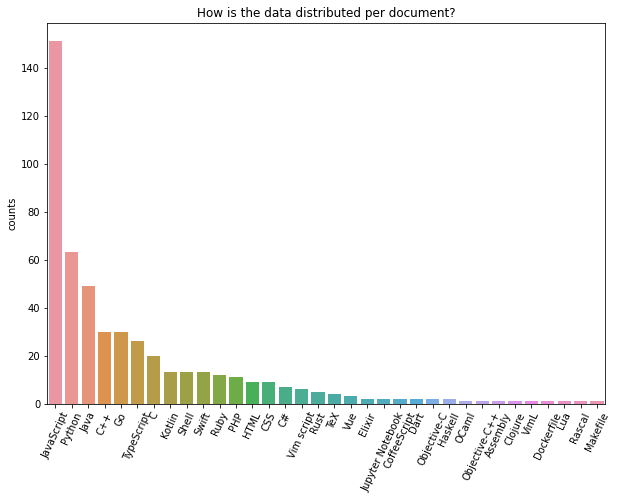

In [15]:
plt.figure(figsize=(10,7))
bar = sns.barplot(x=value_counts.index, y="language", data=value_counts)
bar.set_xticklabels(bar.get_xticklabels(),rotation=65)
bar.set_ylabel("counts")

plt.title("How is the data distributed per document?")
plt.show()

Question 1: Does the length of the README vary by programming language?

In [16]:
#look at the lengths per readme so we can compare by language
df_length = df.assign(length = df.clean_lemmatized.apply(len))

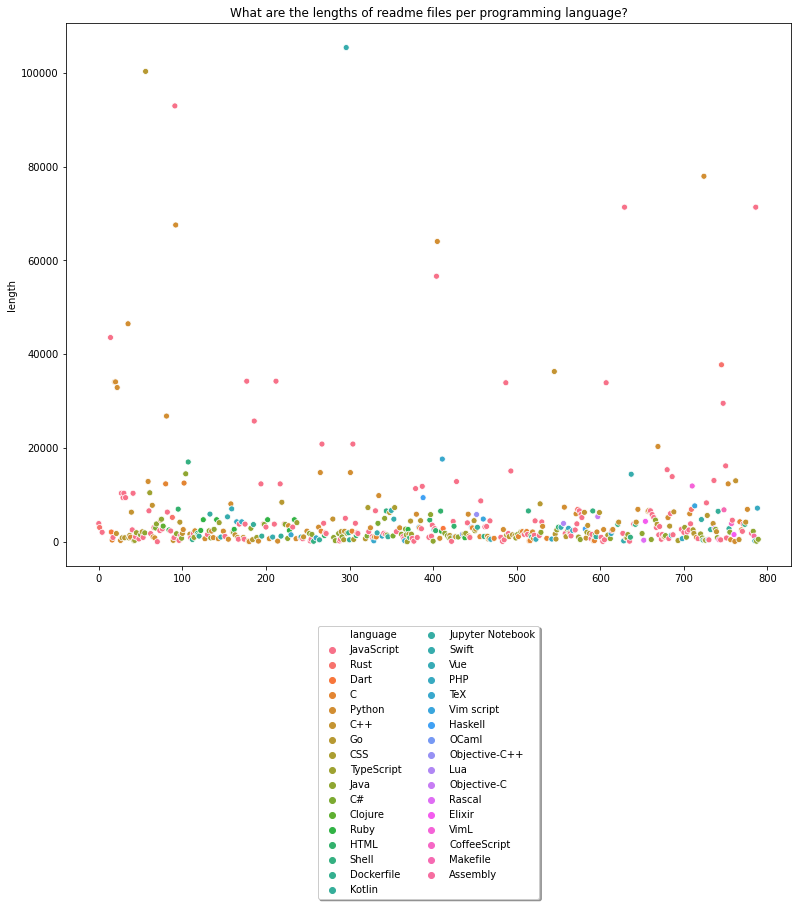

In [17]:
plt.figure(figsize=(13,10))
ax = plt.subplot(111)

plt.title("What are the lengths of readme files per programming language?")
sns.scatterplot(y=df_length.length, x=df_length.index,hue=df_length.language)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2)
plt.show()

Takeaways
- It looks like most readmes have under 25k characters
- Pyhton and Swift seem to have a few outliers

### Lets take a look at the medians, min, and max

In [18]:
median_lengths = df_length.groupby("language").median().sort_values(by="length", ascending= False)
max_length = pd.DataFrame(df_length.groupby("language").length.max().sort_values(ascending= False))
min_length = pd.DataFrame(df_length.groupby("language").length.min().sort_values(ascending= False))

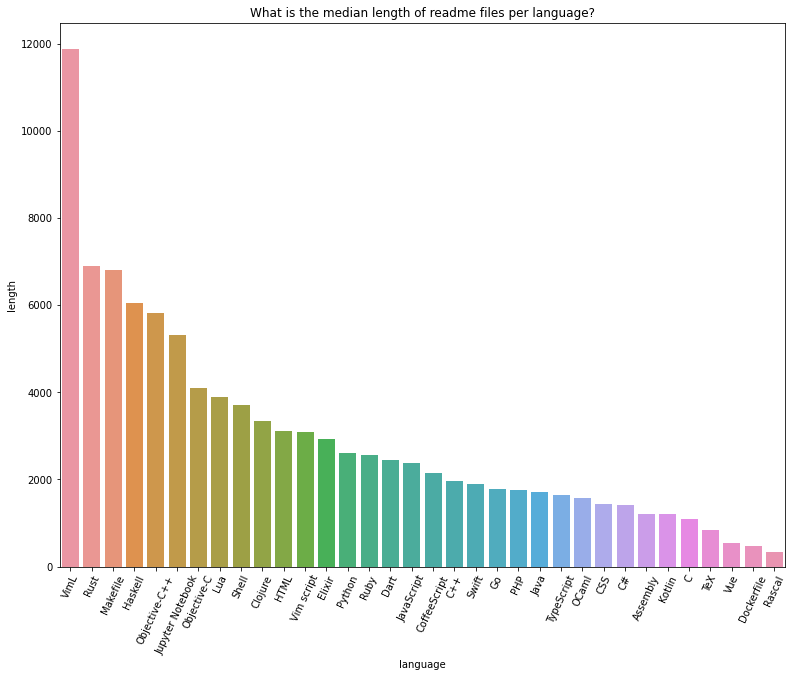

In [19]:
plt.figure(figsize=(13,10))
plt.title("What is the median length of readme files per language?")
bar = sns.barplot(y=median_lengths.length,x=median_lengths.index)

bar.set_xticklabels(bar.get_xticklabels(),rotation=65)
plt.show()

Takeaways:
- Swift has the highest median but this is most likely because of the outlier we found in the scatterplot

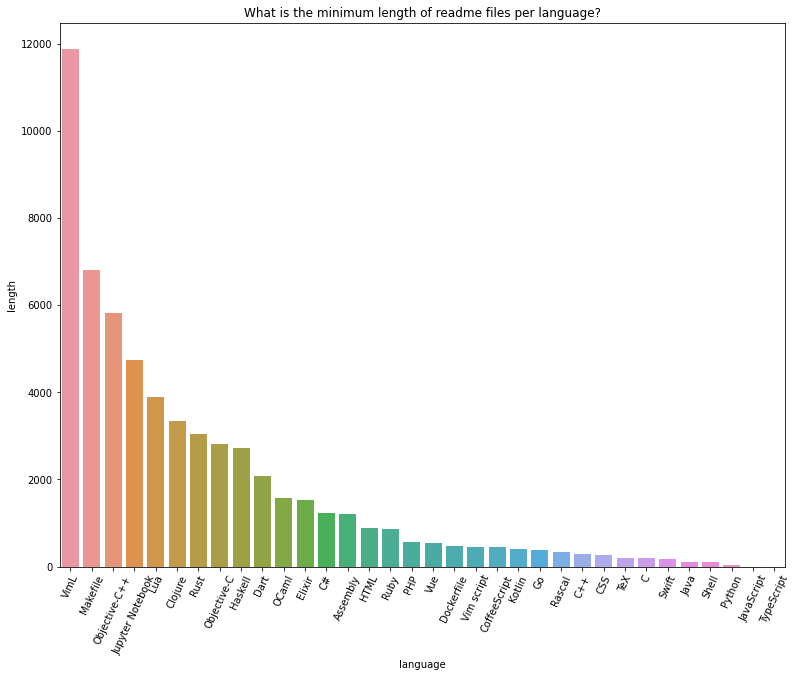

In [20]:
plt.figure(figsize=(13,10))
plt.title("What is the minimum length of readme files per language?")
bar = sns.barplot(y=min_length.length,x=min_length.index)

bar.set_xticklabels(bar.get_xticklabels(),rotation=65)
plt.show()

Takeaways:
- Haskell has the highest min lenght of readmes and Pyhton, JavaScript and C++ have the lowest.

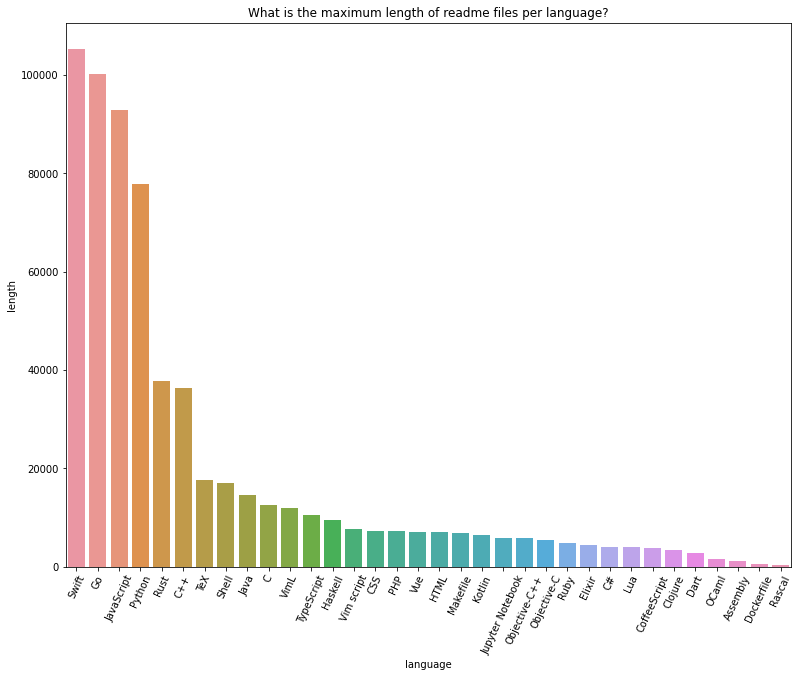

In [21]:
plt.figure(figsize=(13,10))
plt.title("What is the maximum length of readme files per language?")
bar = sns.barplot(y=max_length.length,x=max_length.index)

bar.set_xticklabels(bar.get_xticklabels(),rotation=65)
plt.show()

Takeaways:
- Again here we see that swift is leading the pack with the max length

Question: Do different programming languages use a different number of unique words?

In [22]:
#Our top five languages
value_counts[:5]

,language
JavaScript,151
Python,63
Java,49
C++,30
Go,30


In [23]:
small_df = df[["language", "readme_contents"]]

In [24]:
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (text.encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split() # tokenization
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [25]:
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=14)

In [26]:
# pd.Series(javascript_words).nunique()

NameError: name 'javascript_words' is not defined

In [27]:
# pd.Series(pyhton_words).nunique()

In [28]:
# pd.Series(java_words).nunique()

In [29]:
# pd.Series(go_words).nunique()

In [30]:
# pd.Series(cplus_words).nunique()

Takeaways:
- looks like Pyhton uses the most number of unique words

In [31]:
javascript = df[small_df.language == "JavaScript"]
pyhton = df[small_df.language == "Python"]
java = df[small_df.language == "Java"]
cplus = df[small_df.language == "C++"]

In [32]:
df.loc[(df.language != "Python") & (df.language !="Java") & (df.language !="JavaScript") & (df.language !="C++"), 'is_top_language'] = 'other'
df.is_top_language = df.is_top_language.fillna(df.language)

In [33]:
word = "jfnjkf kdflgjfdkl kdalfgkldfn sdlkgndlksn"

In [34]:
def word_count(word):
    word_count = len(re.findall(r'\w+', word))
    return word_count

In [35]:
df["word_count"] = df.clean_lemmatized.apply(word_count)

In [36]:
df

,repo,language,readme_contents,clean_tokes,clean_lemmatized,is_top_language,word_count
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,"[freecodecamporg, social, bannerhttpss3amazona...",social pull request open source setup opensour...,JavaScript,529
1,996icu/996.ICU,Rust,[996.ICU](https://996.icu/#/en_US) ======= **P...,"[996icuhttps996icuen_us, please, note, that, t...",please note exists official account app mercha...,other,428
4,facebook/react,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...,"[reacthttpsreactjsorg, middot, github, license...",middot github npm circleci pr react javascript...,JavaScript,286
14,airbnb/javascript,JavaScript,# Airbnb JavaScript Style Guide() { *A mostly...,"[airbnb, javascript, style, guide, a, mostly, ...",airbnb javascript style guide mostly reasonabl...,JavaScript,6503
15,flutter/flutter,Dart,# [![Flutter logo][]][flutter.dev] [![Build S...,"[flutter, logoflutterdev, build, status, cirru...",flutter build status cirrusbuild status gitter...,other,274
...,...,...,...,...,...,...,...
785,ipader/SwiftGuide,Swift,"<a href=""https://www.vultr.com/?ref=7229348""><...","[a, hrefhttpswwwvultrcomref7229348img, srchttp...",width364 height45a swift 2014 wwdc swift swift...,other,27
786,poteto/hiring-without-whiteboards,JavaScript,# Hiring Without Whiteboards A list of compan...,"[hiring, without, whiteboards, a, list, of, co...",hiring without whiteboards list company team d...,JavaScript,9694
787,hollischuang/toBeTopJavaer,Java,## To Be Top Javaer - Java工程师成神之路 ![](https...,"[to, be, top, javaer, java, httpsimgshieldsiob...",top javaer java v30 20200331 page v20 20190219...,Java,20
788,PHPMailer/PHPMailer,PHP,![PHPMailer](https://raw.github.com/PHPMailer/...,[phpmailerhttpsrawgithubcomphpmailerphpmailerm...,phpmailer fullfeatured email creation transfer...,other,1009


In [37]:
min_word_count = pd.DataFrame(df.groupby("is_top_language").word_count.min())
min_word_count.columns = ['Min Word Count']

max_word_count = pd.DataFrame(df.groupby("is_top_language").word_count.max())
max_word_count.columns = ["Max Word Count"]

median_word_count = pd.DataFrame(df.groupby("is_top_language").word_count.median())
median_word_count.columns = ["Median Word Count"]

mean_word_count = pd.DataFrame(df.groupby("is_top_language").word_count.mean())
mean_word_count.columns = ["Mean Word Count"]

std_word_count = pd.DataFrame(df.groupby("is_top_language").word_count.std())
std_word_count.columns = ["STD of Word Count"]

In [38]:
summary1 = pd.merge(min_word_count, max_word_count, left_index=True, right_index=True)
summary2 = pd.merge(median_word_count , mean_word_count , left_index=True, right_index=True)
summary3 = pd.merge(summary1 , summary2 , left_index=True, right_index=True)
summary = pd.merge(summary3 , std_word_count , left_index=True, right_index=True)

In [39]:
def word_count_summary(df):
    "returs a summary of the top language word counts"
    min_word_count = pd.DataFrame(df.groupby("is_top_language").word_count.min())
    min_word_count.columns = ['Min Word Count']

    max_word_count = pd.DataFrame(df.groupby("is_top_language").word_count.max())
    max_word_count.columns = ["Max Word Count"]

    median_word_count = pd.DataFrame(df.groupby("is_top_language").word_count.median())
    median_word_count.columns = ["Median Word Count"]

    mean_word_count = pd.DataFrame(df.groupby("is_top_language").word_count.mean())
    mean_word_count.columns = ["Mean Word Count"]

    std_word_count = pd.DataFrame(df.groupby("is_top_language").word_count.std())
    std_word_count.columns = ["STD of Word Count"]
    
    summary1 = pd.merge(min_word_count, max_word_count, left_index=True, right_index=True)
    summary2 = pd.merge(median_word_count , mean_word_count , left_index=True, right_index=True)
    summary3 = pd.merge(summary1 , summary2 , left_index=True, right_index=True)
    summary = pd.merge(summary3 , std_word_count , left_index=True, right_index=True)
    
    return summary

In [40]:
word_count_summary(df)

,Min Word Count,Max Word Count,Median Word Count,Mean Word Count,STD of Word Count
is_top_language,,,,,
C++,42,5361,274.5,586.533333,984.070916
Java,19,1975,250.0,303.551020,307.224881
JavaScript,0,13001,325.0,1003.463576,1934.159000
Python,3,9791,386.0,1331.857143,2240.496869
other,0,16233,281.0,589.955446,1558.114207


In [41]:
summary

,Min Word Count,Max Word Count,Median Word Count,Mean Word Count,STD of Word Count
is_top_language,,,,,
C++,42,5361,274.5,586.533333,984.070916
Java,19,1975,250.0,303.551020,307.224881
JavaScript,0,13001,325.0,1003.463576,1934.159000
Python,3,9791,386.0,1331.857143,2240.496869
other,0,16233,281.0,589.955446,1558.114207


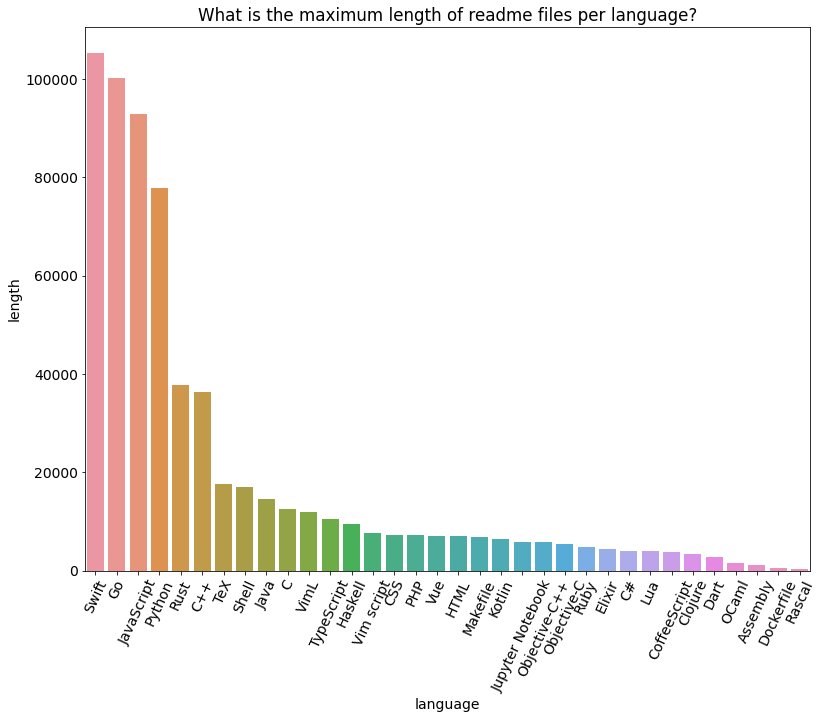

In [42]:
plt.figure(figsize=(13,10))
plt.title("What is the maximum length of readme files per language?")
bar = sns.barplot(y=max_length.length,x=max_length.index)

bar.set_xticklabels(bar.get_xticklabels(),rotation=65)
plt.show()

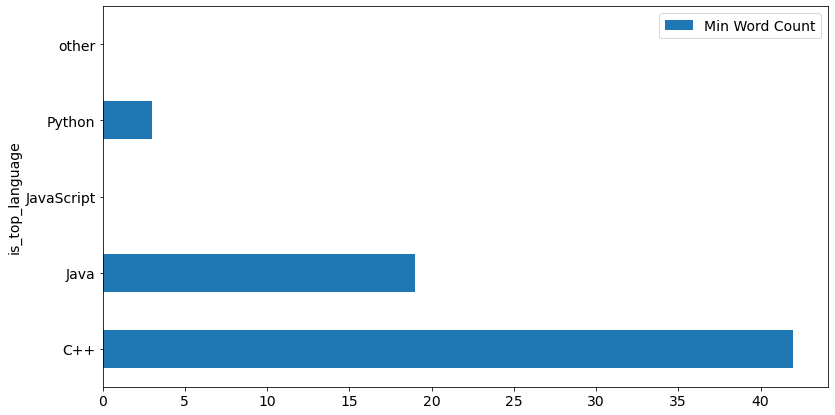

In [43]:
min_word_count.plot.barh()

In [44]:
javascript.clean_tokes[:1]

0    [freecodecamporg, social, bannerhttpss3amazona...
Name: clean_tokes, dtype: object

In [45]:
def word_freq(dfx, language="language", cleaned="clean_lemmatized"):
    # create list of words by language

    js_words = ' '.join(dfx[dfx[language] == 'JavaScript'][cleaned]).split()
    p_words = ' '.join(dfx[dfx[language] == 'Python'][cleaned]).split()
    j_words = ' '.join(dfx[dfx[language] == 'Java'][cleaned]).split()
    php_words = ' '.join(dfx[dfx[language] == 'PHP'][cleaned]).split()
    go_words = ' '.join(dfx[dfx[language] == 'Go'][cleaned]).split()
    jup_words = ' '.join(dfx[dfx[language] == 'Jupyter Notebook'][cleaned]).split()
    html_words = ' '.join(dfx[dfx[language] == 'HTML'][cleaned]).split()
    swift_words = ' '.join(dfx[dfx[language] == 'Swift'][cleaned]).split()
    ts_words = ' '.join(dfx[dfx[language] == 'TypeScript'][cleaned]).split()
    ruby_words = ' '.join(dfx[dfx[language]== 'Ruby'][cleaned]).split()
    cpp_words = ' '.join(dfx[dfx[language] == 'C++'][cleaned]).split()
    css_words = ' '.join(dfx[dfx[language] == 'CSS'][cleaned]).split()
    shell_words = ' '.join(dfx[dfx[language] == 'Shell'][cleaned]).split()
    c_words = ' '.join(dfx[dfx[language] == 'C'][cleaned]).split()
    csharp_words = ' '.join(dfx[dfx[language] == 'C#'][cleaned]).split()
    all_words = ' '.join(dfx[cleaned]).split()

    # create Series of word frequency by language

    js_freq = pd.Series(js_words).value_counts()
    p_freq = pd.Series(p_words).value_counts()
    j_freq = pd.Series(j_words).value_counts()
    php_freq = pd.Series(php_words).value_counts()
    go_freq = pd.Series(go_words).value_counts()
    jup_freq = pd.Series(jup_words).value_counts()
    html_freq = pd.Series(html_words).value_counts()
    swift_freq = pd.Series(swift_words).value_counts()
    ts_freq = pd.Series(ts_words).value_counts()
    ruby_freq = pd.Series(ruby_words).value_counts()
    cpp_freq = pd.Series(cpp_words).value_counts()
    css_freq = pd.Series(css_words).value_counts()
    shell_freq = pd.Series(shell_words).value_counts()
    c_freq = pd.Series(c_words).value_counts()
    csharp_freq = pd.Series(csharp_words).value_counts()
    all_freq = pd.Series(all_words).value_counts()

    # Combine Series' together into df
    word_counts = (pd.concat([all_freq, js_freq, p_freq, j_freq, php_freq, go_freq, jup_freq, html_freq, swift_freq, ts_freq, ruby_freq, cpp_freq, css_freq, c_freq, csharp_freq], axis=1, sort=True)
     .set_axis(['all', 'javascript', 'python', 'java', 'php', 'go', 'jupyter_notebook', 'html', 'swift', 'typescript', 'ruby', 'C+', 'CSS', 'C', 'C#'], axis=1, inplace=False)
     .fillna(0)
     .apply(lambda s: s.astype(int)))
    
    return word_counts

In [46]:
def lis_of_words_for_top_languages(dfx, language="is_top_language", cleaned="clean_lemmatized"):
    """Creates a list of words for each language in the top programming languages
    returns in this order:
    java script words, python words, java words, C++ words, other languages words, all words
    """
    # create list of words by language

    js_words = ' '.join(dfx[dfx[language] == 'JavaScript'][cleaned]).split()
    p_words = ' '.join(dfx[dfx[language] == 'Python'][cleaned]).split()
    j_words = ' '.join(dfx[dfx[language] == 'Java'][cleaned]).split()
    cpp_words = ' '.join(dfx[dfx[language] == 'C++'][cleaned]).split()
    other_words = ' '.join(dfx[dfx[language] == 'other'][cleaned]).split()
    all_words = ' '.join(dfx[cleaned]).split()
    
    return js_words, p_words, j_words, cpp_words, other_words, all_words

In [47]:
js_words, p_words, j_words, cpp_words, other_words, all_words = lis_of_words_for_top_languages(df, language="is_top_language", cleaned="clean_lemmatized")

# Bigrams

In [48]:
top_20_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))

top_20_js_bigrams = (pd.Series(nltk.ngrams(js_words, 2))
                      .value_counts()
                      .head(20))

top_20_p_bigrams = (pd.Series(nltk.ngrams(p_words, 2))
                      .value_counts()
                      .head(20))

top_20_j_bigrams = (pd.Series(nltk.ngrams(j_words, 2))
                      .value_counts()
                      .head(20))

top_20_cpp_bigrams = (pd.Series(nltk.ngrams(cpp_words, 2))
                      .value_counts()
                      .head(20))

top_20_other_bigrams = (pd.Series(nltk.ngrams(other_words, 2))
                      .value_counts()
                      .head(20))

In [49]:
top_20_bigrams

(detail, &#9;)               884
(summary, &#9;)              880
(yes, unknown)               878
(&#9;, added)                874
(&#9;, 1codea)               795
(opensource, softwareoss)    727
(&#9;, summary)              715
(&#9;, &#9;)                 693
(license, &#9;)              593
(&#9;, trtd)                 490
(1codea, detail)             458
(apikey, yes)                450
(open, source)               399
(1, 1)                       351
(takehome, project)          344
(1codea, 2codea)             337
(app, detail)                335
(alignleft, &#9;)            302
(machine, learning)          294
(2016br, license)            284
dtype: int64

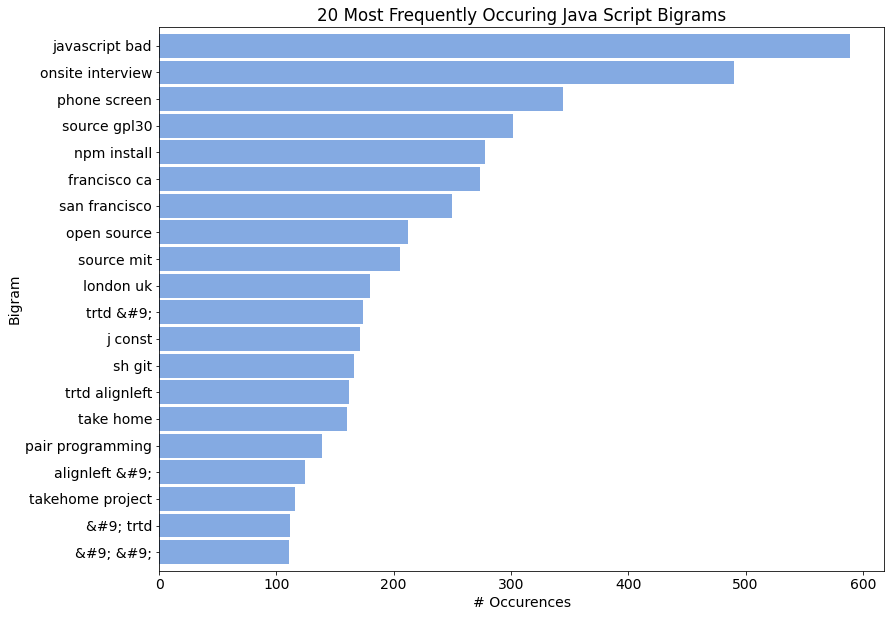

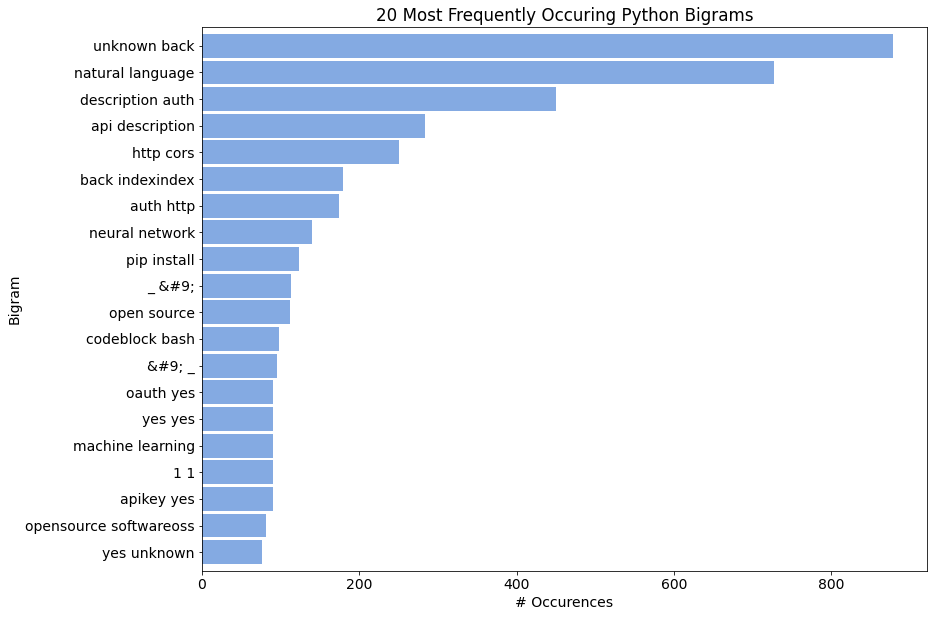

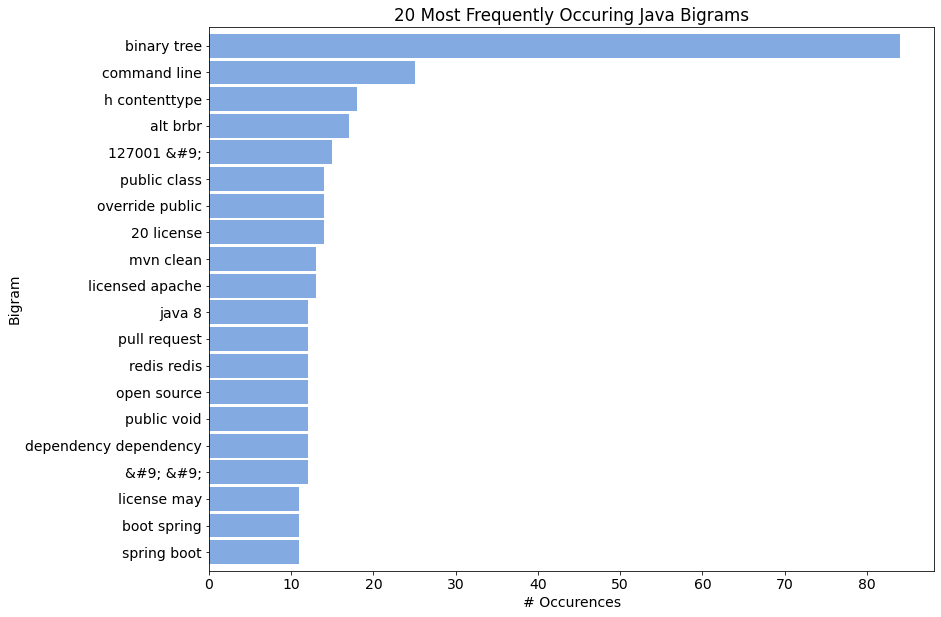

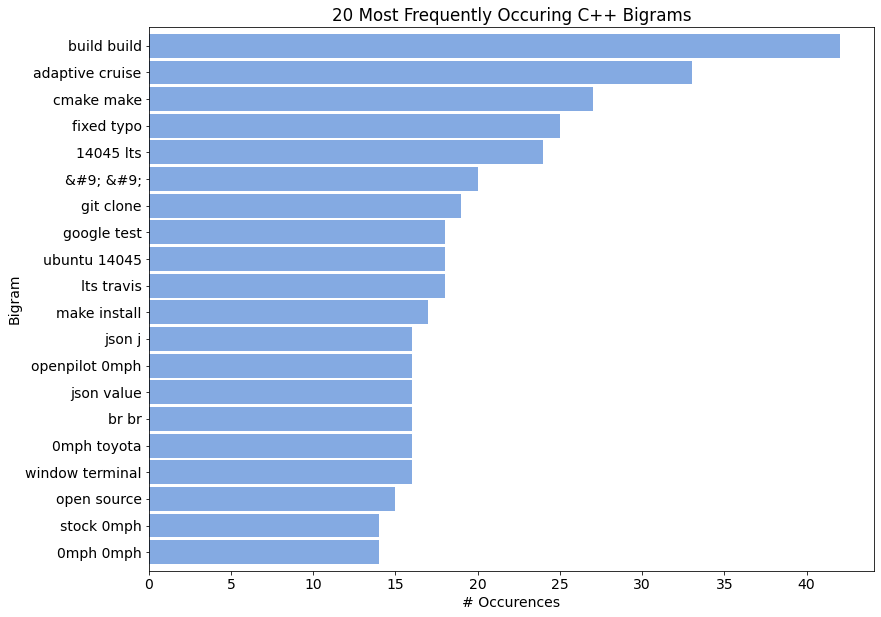

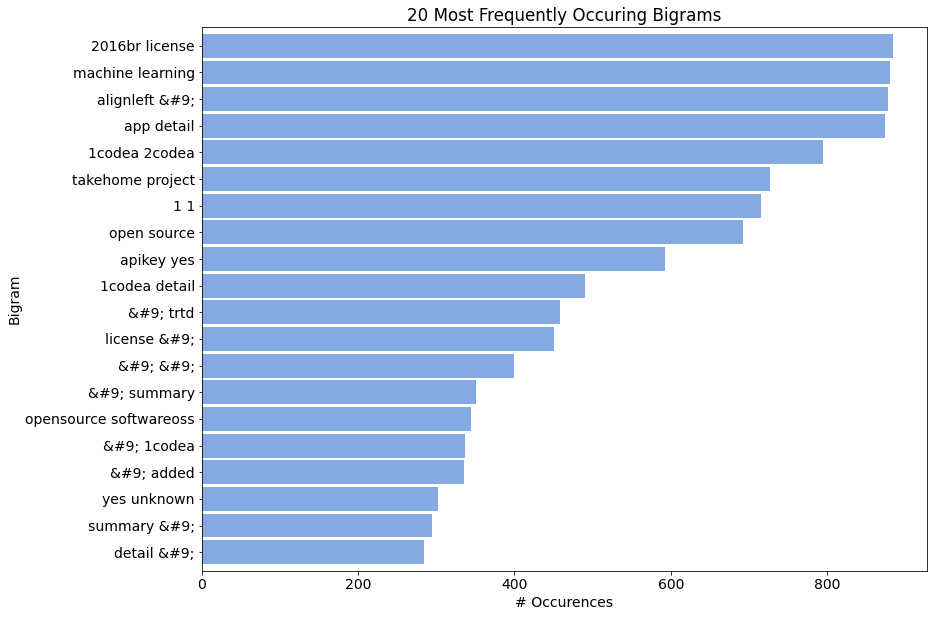

In [50]:
c="#84aae2"


top_20_js_bigrams.sort_values().plot.barh(color=c, width=.9, figsize=(13, 10))
plt.title('20 Most Frequently Occuring Java Script Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurences')
# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_js_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)
plt.show()


top_20_p_bigrams.sort_values().plot.barh(color=c, width=.9, figsize=(13, 10))
plt.title('20 Most Frequently Occuring Python Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurences')
# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_p_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)
plt.show()

top_20_j_bigrams.sort_values().plot.barh(color=c, width=.9, figsize=(13,10))
plt.title('20 Most Frequently Occuring Java Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurences')
# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_j_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)
plt.show()

top_20_cpp_bigrams.sort_values().plot.barh(color=c, width=.9, figsize=(13,10))
plt.title('20 Most Frequently Occuring C++ Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurences')
# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_cpp_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)
plt.show()

top_20_bigrams.sort_values().plot.barh(color=c, width=.9, figsize=(13,10))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurences')
# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)
plt.show()

# Word Clouds

In [166]:
def word_cloud(text, photo_file_name):
    plt.figure(figsize=(13, 13))
    custom_mask = np.array(Image.open(photo_file_name))
    image_colors = ImageColorGenerator(custom_mask)
    cloud = WordCloud(background_color='white', mask=custom_mask, contour_width=10, contour_color="black").generate(' '.join(text))
    cloud.recolor(color_func=image_colors)
    plt.imshow(cloud)
    plt.axis('off')

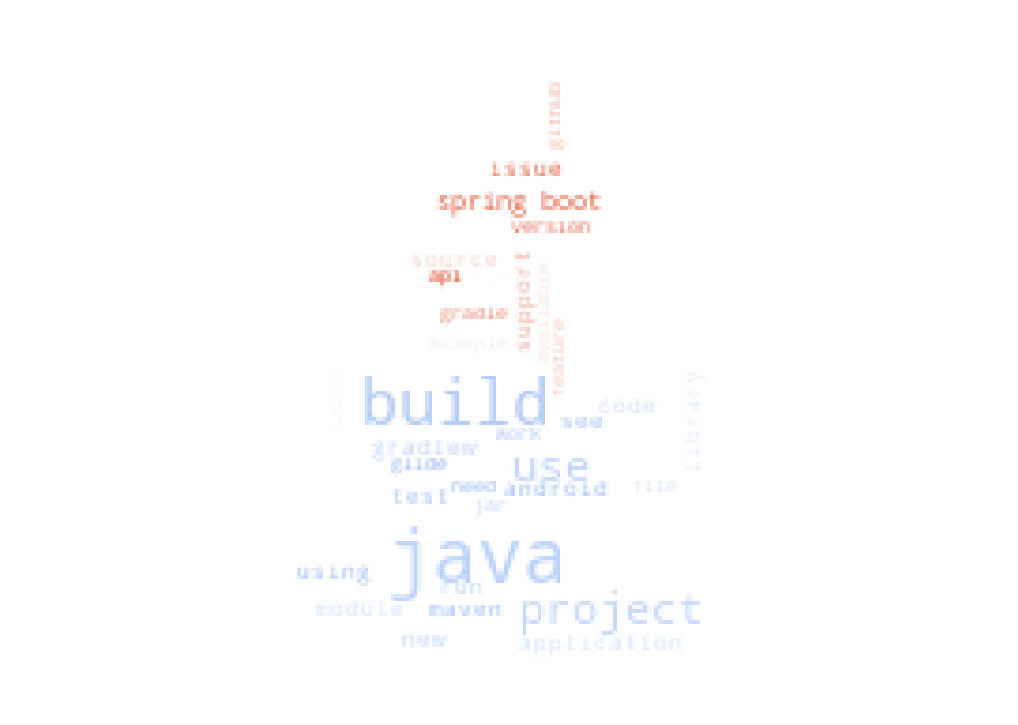

In [55]:
custom_mask = np.array(Image.open("javalogo.jpeg"))
image_colors = ImageColorGenerator(custom_mask)
plt.figure(figsize=(18, 18))
wc = WordCloud(background_color='white', mask=custom_mask, height=4000, width=4000).generate(' '.join(j_words))
wc.recolor(color_func=image_colors)
plt.imshow(wc)
plt.axis("off")
plt.show()

In [156]:
df.language

0      JavaScript
1            Rust
4      JavaScript
14     JavaScript
15           Dart
          ...    
785         Swift
786    JavaScript
787          Java
788           PHP
789          Java
Name: language, Length: 495, dtype: object

In [157]:
words = df.language

In [ ]:
plt.figure(figsize=(13, 13))
custom_mask = np.array(Image.open(photo_file_name))
image_colors = ImageColorGenerator(custom_mask)
cloud = WordCloud(background_color='white', mask=custom_mask, contour_width=10, contour_color="black").generate(' '.join(text))
cloud.recolor(color_func=image_colors)
plt.imshow(cloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

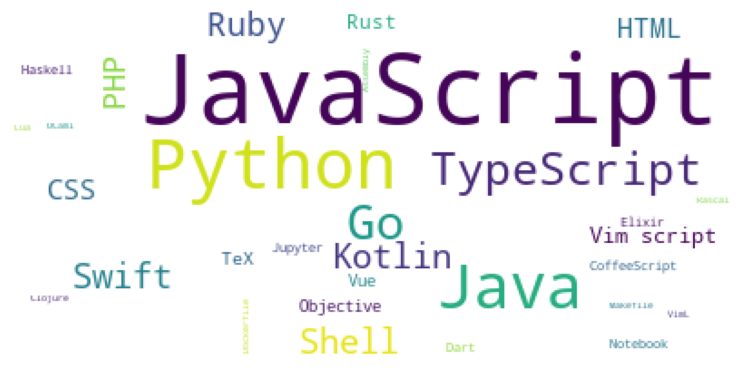

In [182]:
custom_mask = np.array(Image.open("question.jpg"))
cloud = WordCloud(background_color='white').generate(' '.join(words))

plt.imshow(cloud)
plt.axis('off')

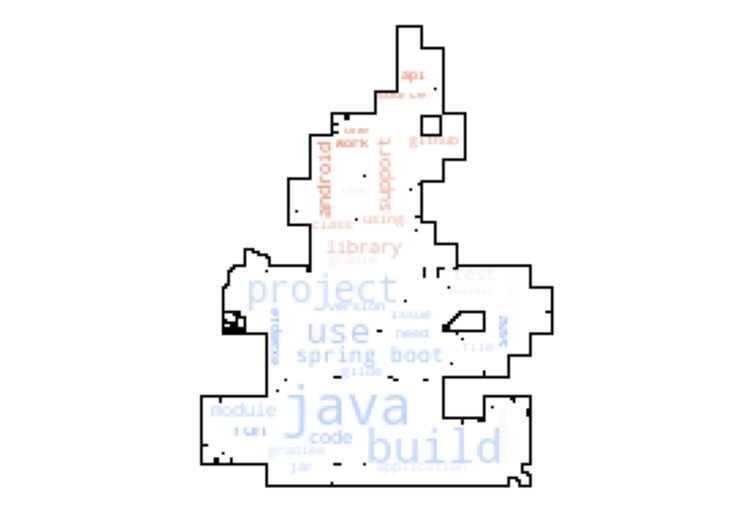

In [152]:
word_cloud(j_words, "javalogo.jpeg")

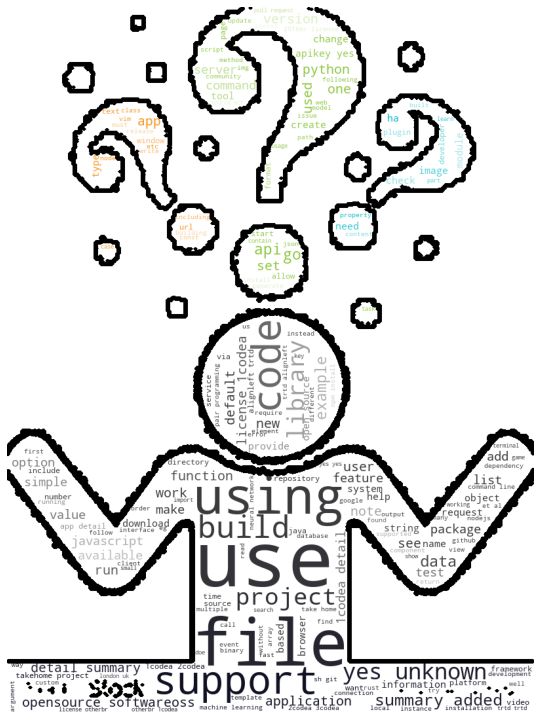

In [167]:
word_cloud(all_words, "person.jpg")

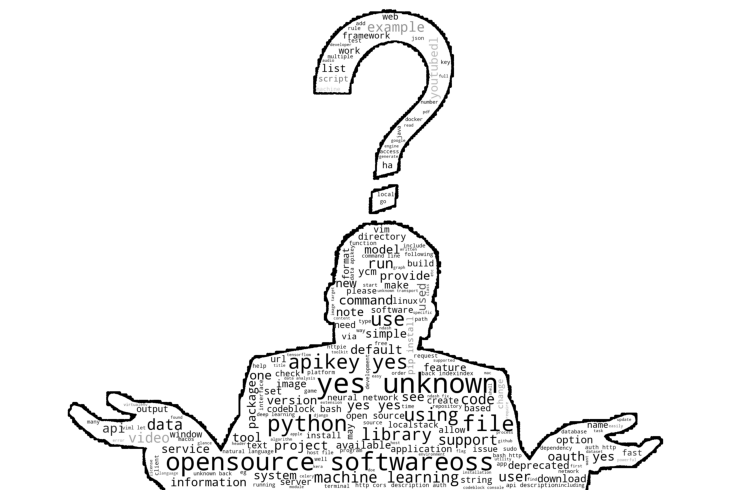

In [168]:
word_cloud(p_words, "it.jpg")

In [ ]:
plt.figure(figsize=(13, 13))

all_cloud = WordCloud(background_color='white', height=1000, width=1000).generate(' '.join(all_words))

plt.imshow(all_cloud)

In [ ]:
plt.axis('off')

# To add to main notebook


## Counts for character, sentence

In [ ]:
df["char_count"] = df.readme_contents.apply(len)

In [ ]:
df["sentence_count"] = df.readme_contents.apply(nltk.sent_tokenize).apply(len)

In [ ]:
df

In [ ]:
sns.relplot(data=df, y='word_count', x='char_count', hue='is_top_language')

In [ ]:
sns.pairplot(df, hue='is_top_language')

In [ ]:
df

In [ ]:
string = "sdjfdjkjkdgbjkdfbgjkdfbvjkdfnbvj gkfgdf kjfgjkf"

In [ ]:
new_word = []
for word in string.split():
    if len(word) <= 12:
        new_word.append(word)
new_word = " ".join(new_word)

In [ ]:
new_word

In [ ]:
string.split()

In [ ]:
def drop_long_words(string):    
    new_word = []
    for word in string.split():
        if len(word) <= 12:
            new_word.append(word)
    new_word = " ".join(new_word)
    return new_word

In [ ]:
string = "sdjfdjkjkdgbjkdfbgjkdfbvjkdfnbvj gkfgdf kjfgjkf"

In [ ]:
drop_long_words(string)

In [ ]:
df.clean_lemmatized = df.clean_lemmatized.apply(drop_long_words)

In [ ]:
df

In [ ]:
stopword_list = stopwords.words('english')

In [ ]:
stopword_list

In [ ]:
string = """ python is awesome sauce jdfngjfkdnb kdjffjknv dkjgndjkd kj;dkjdb v dgklnhdfknbgfdjl 
python is awesome sauce jdfngjfkdnb kdjffjknv dkjgndjkd kj;dkjdb v dgklnhdfknbgfdjl
python is awesome sauce jdfngjfkdnb kdjffjknv dkjgndjkd kj;dkjdb v dgklnhdfknbgfdjl 
python is awesome sauce jdfngjfkdnb kdjffjknv dkjgndjkd kj;dkjdb v dgklnhdfknbgfdj
python is awesome sauce jdfngjfkdnb kdjffjknv dkjgndjkd kj;dkjdb v dgklnhdfknbgfdjl 
python is awesome sauce jdfngjfkdnb kdjffjknv dkjgndjkd kj;dkjdb v dgklnhdfknbgfdjl
python is awesome sauce jdfngjfkdnb kdjffjknv dkjgndjkd kj;dkjdb v dgklnhdfknbgfdjl 
python is awesome sauce jdfngjfkdnb kdjffjknv dkjgndjkd kj;dkjdb v dgklnhdfknbgfdj
python is awesome sauce jdfngjfkdnb kdjffjknv dkjgndjkd kj;dkjdb v dgklnhdfknbgfdjl 
python is awesome sauce jdfngjfkdnb kdjffjknv dkjgndjkd kj;dkjdb v dgklnhdfknbgfdjl
python is awesome sauce jdfngjfkdnb kdjffjknv dkjgndjkd kj;dkjdb v dgklnhdfknbgfdjl 
python is awesome sauce jdfngjfkdnb kdjffjknv dkjgndjkd kj;dkjdb v dgklnhdfknbgfdj
python is awesome sauce jdfngjfkdnb kdjffjknv dkjgndjkd kj;dkjdb v dgklnhdfknbgfdjl 
python is awesome sauce jdfngjfkdnb kdjffjknv dkjgndjkd kj;dkjdb v dgklnhdfknbgfdjl
python is awesome sauce jdfngjfkdnb kdjffjknv dkjgndjkd kj;dkjdb v dgklnhdfknbgfdjl 
python is awesome sauce jdfngjfkdnb kdjffjknv dkjgndjkd kj;dkjdb v dgklnhdfknbgfdj"""
custom_mask= np.array(Image.open("pythonlogo.jpeg"))
wc = WordCloud(background_color="white", mask=custom_mask)

In [ ]:
wc.generate(string)

In [ ]:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()